# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, when, split, udf, isnull, count,  mean, stddev, round
from pyspark.sql.types import IntegerType, StringType, DateType
from pyspark.sql.functions import to_date, datediff



from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.feature import StringIndexer, VectorAssembler, Normalizer, StandardScaler, MinMaxScaler
from pyspark.ml.feature import OneHotEncoder, StringIndexer, OneHotEncoderEstimator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.mllib.util import MLUtils

from pyspark.sql import Window

import re
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import numpy as np



In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [3]:
# Read in full sparkify dataset
# event_data = "s3n://dsnd-sparkify/sparkify_event_data.json"
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)
df_ml = df
df.persist()


DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
df.count()

286500

In [5]:
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df.count()

286500

In [6]:
df = df.filter(df.userId!="")
df.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [7]:
print('There are {users} unique users in the dataset.'.format( users = df.select('userId').distinct().count()))


There are 225 unique users in the dataset.


In [8]:
print('There are {} lines in the dataset.  Each line corresponds to an event for a user, who signed in.'\
     .format(df.count()))

There are 278154 lines in the dataset.  Each line corresponds to an event for a user, who signed in.


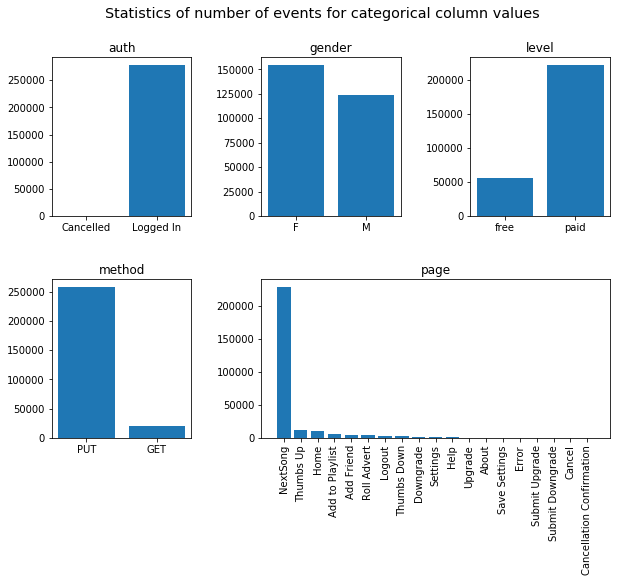

In [9]:
# plot bar charts with number of events with respect to categorical values

cat_columns = ['auth', 'gender', 'level', 'method']

fig = plt.figure(figsize=(10, 7))
st = fig.suptitle("Statistics of number of events for categorical column values", fontsize="x-large")

grid = plt.GridSpec(2, 3, hspace=0.4, wspace=0.5)

counter = 0
for cat_column in cat_columns:
    
    value_counts = df.groupBy(cat_column).count().toPandas()
    
    trace_x = counter // 3
    trace_y = counter % 3
    
    x_pos = np.arange(0, len(value_counts))
    
    hist_ax = fig.add_subplot(grid[trace_x, trace_y])
    
    hist_ax.bar(x_pos, value_counts['count'].values, tick_label = value_counts[cat_column].values)
    
    hist_ax.set_title(cat_column)
    
    counter += 1

page_ax = fig.add_subplot(grid[1 , 1:])

value_counts = df.groupBy('page').count().orderBy('count', ascending=False).toPandas()

x_pos = np.arange(0, len(value_counts))

page_ax.bar(x_pos, value_counts['count'].values, tick_label = value_counts['page'].values)

page_ax.set_title('page')
    
for tick in page_ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()

In [10]:
# calculate the number of paid and free accounts

paid = df.select('userId', 'level').where(df.level == 'paid').groupBy('userId').count().agg(count("count"))
free = df.select('userId', 'level').where(df.level == 'free').groupBy('userId').count().agg(count("count"))

print('There are {paid} paid and {free} free accounts in dataset.'\
      .format(paid = paid.collect()[0]["count(count)"],\
             free = free.collect()[0]["count(count)"]))

There are 165 paid and 195 free accounts in dataset.


In [11]:
# calculate the number of female and male users

male = df.select('userId', 'gender').where(df.gender == 'M').groupBy('userId').count().agg(count("count"))
female = df.select('userId', 'gender').where(df.gender == 'F').groupBy('userId').count().agg(count("count"))

print('There are {male} male and {female} female users in dataset.'\
      .format(male = male.collect()[0]["count(count)"],\
             female = female.collect()[0]["count(count)"]))

There are 121 male and 104 female users in dataset.


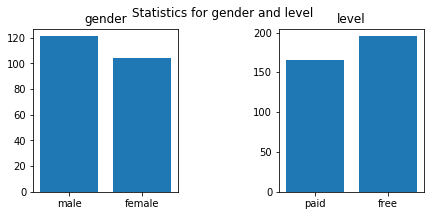

In [12]:
#Visualizing the result

fig = plt.figure(figsize=(7, 3))
st = fig.suptitle("Statistics for gender and level")

grid = plt.GridSpec(1, 2, hspace=0.4, wspace=0.7)

x_pos = np.arange(0, 2)

gender_ax = fig.add_subplot(grid[0 , 0])

level_ax = fig.add_subplot(grid[0 , 1])

gender_ax.bar(x_pos, [male.collect()[0]["count(count)"], female.collect()[0]["count(count)"]], \
              tick_label = ['male', 'female'])
gender_ax.set_title('gender')

level_ax.bar(x_pos, [paid.collect()[0]["count(count)"], free.collect()[0]["count(count)"]], \
              tick_label = ['paid', 'free'])
level_ax.set_title('level')

plt.show()

In [13]:
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [14]:
#checking user who actually canceled
df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates().count()

52

In [15]:
# add time to see the time clear
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("time", get_time(df.ts))

In [16]:
#df.select(["userId", "page", "time", "level", "song", "sessionId"]).where(df.userId == "74").sort("time").show(100)

In [17]:
#df.select(["userId", "page", "time", "level", "song", "sessionId"]).where(df.userId == "60").sort("time").show(100)

### From the preliminary analysis we can tell that:

There are more male users than female users in the dataset and the number of events corresponding to male users is greater than the number of events for female users.
There are fewer paid level users than free level users, but the number of events for paid users is greater than the number of events for free level users. This means that paid users are more active.

### Define Churn

In [18]:
# adding churn
churn_users = df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()
churn_users_list = [(row['userId']) for row in churn_users.collect()]
df_withchurn = df.withColumn("churn", df.userId.isin(churn_users_list))

In [19]:
#description by user demograph
df_withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|false|     M|   89|
|false|     F|   84|
| true|     F|   20|
| true|     M|   32|
+-----+------+-----+



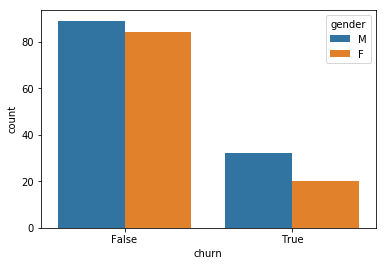

In [20]:
# Visualization
df_pd = df_withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='gender', data=df_pd)

In [21]:
# get userId with churn == 1
cancelled_users = df_withchurn.select('userId', 'churn').filter(df_withchurn['churn'] == True).distinct()

In [22]:
# get number of users, who churned
print('{} users churned.'.format(cancelled_users.count()))

52 users churned.


In [23]:
# digging deep into page use.
churn_count = df_withchurn.filter(df_withchurn.churn==1).count()
no_churn_count = df_withchurn.filter(df_withchurn.churn==0).count()

df_temp1 = df_withchurn.filter(df_withchurn.churn==1).filter(df_withchurn.page!="NextSong").groupby(["page"]).count()
df_temp1 = df_temp1.withColumn("cFreq", df_temp1["count"]/(churn_count/100)).sort("page")

df_temp2 = df_withchurn.filter(df_withchurn.churn==0).filter(df_withchurn.page!="NextSong").groupby(["page"]).count()
df_temp2 = df_temp2.withColumn("ncFreq", df_temp2["count"]/(no_churn_count/100)).sort("page")

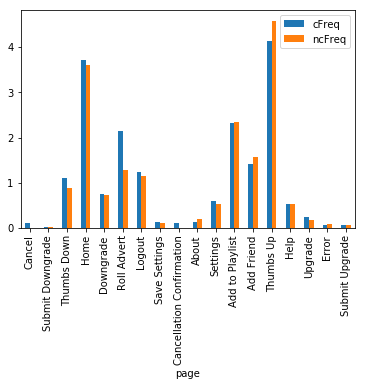

In [24]:
df_pd = df_temp1.join(df_temp2, "page", "outer").drop("count").fillna(0).toPandas()
df_pd.plot.bar("page")

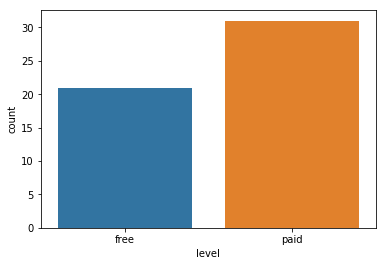

In [25]:
# churn level visuals

df_pd = df_withchurn.filter(df_withchurn.page=="Cancellation Confirmation").groupby("level").count().toPandas()
sns.barplot(x="level", y="count", data=df_pd)

# Exploring the data

In [26]:
# find the number of users who churned and who stayed
churned_users = df_withchurn.select('userId', 'churn').where(df_withchurn['churn'] == True).groupBy('userId').count().count()
stayed_users = df_withchurn.select('userId', 'churn').where(df_withchurn['churn'] == False).groupBy('userId').count().count()

print('The number of users who churned is {}'.format(churned_users))
print('The number of users who didn\'t cancel subscription is {}'.format(stayed_users))

The number of users who churned is 52
The number of users who didn't cancel subscription is 173


We can see that the dataset is imbalanced: number of users who churned is approximately 3 times less than the number of users who stayed. That is why accuracy is probably not the best metric to evaluate our future machine learning model. I suggest to use F1 score to evaluate the model.

### Explore number of events with respect to categorical columns for users who churned and for users who kept subscription:

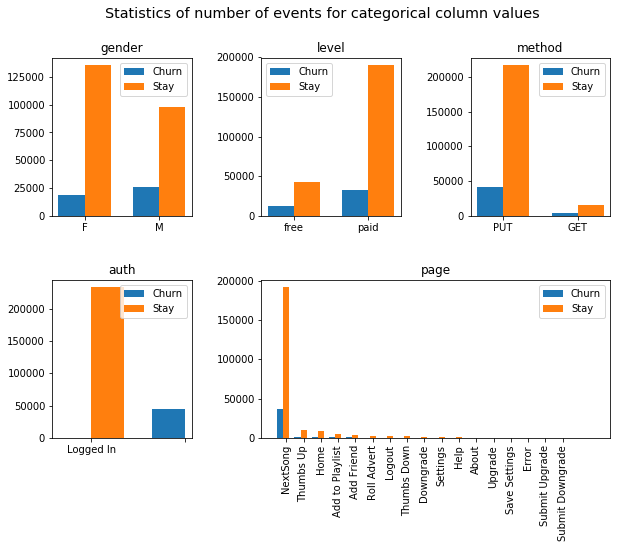

In [27]:
# plot bar charts with values of categorical values

cat_columns = ['gender', 'level', 'method', 'auth']

fig = plt.figure(figsize=(10, 7))
st = fig.suptitle("Statistics of number of events for categorical column values", fontsize="x-large")

grid = plt.GridSpec(2, 3, hspace=0.4, wspace=0.5)
width = 0.35

counter = 0
for cat_column in cat_columns:
    
    trace_x = counter // 3
    trace_y = counter % 3
    
    hist_ax = fig.add_subplot(grid[trace_x, trace_y])
    
    value_counts_churned = df_withchurn.where(df_withchurn['churn'] == True).groupBy(cat_column).count().toPandas()
    value_counts_stayed = df_withchurn.where(df_withchurn['churn'] == False).groupBy(cat_column).count().toPandas()
    
    x_pos_ch = np.arange(0, len(value_counts_churned))
    x_pos_st = np.arange(0, len(value_counts_stayed))
        
    p1 = hist_ax.bar(x_pos_ch, value_counts_churned['count'].values, width, \
                     tick_label = value_counts_churned[cat_column].values)
    p2 = hist_ax.bar(x_pos_st + width, value_counts_stayed['count'].values, width, \
                     tick_label = value_counts_stayed[cat_column].values)
    
    hist_ax.set_title(cat_column)
    hist_ax.set_xticks(x_pos + width / 2)
    
    hist_ax.legend((p1[0], p2[0]), ('Churn', 'Stay'))
    
    counter += 1

page_ax = fig.add_subplot(grid[1 , 1:])

value_counts_churned = df_withchurn.where(df_withchurn['churn'] == True).groupBy('page').count().orderBy('count', ascending=False).toPandas()
value_counts_stayed = df_withchurn.where(df_withchurn['churn'] == False).groupBy('page').count().orderBy('count', ascending=False).toPandas()
    
x_pos_ch = np.arange(0, len(value_counts_churned))
x_pos_st = np.arange(0, len(value_counts_stayed))

p1 = page_ax.bar(x_pos_ch, value_counts_churned['count'].values, width, tick_label = value_counts_churned['page'].values)
p2 = page_ax.bar(x_pos_st + width, value_counts_stayed['count'].values, width, \
                 tick_label = value_counts_stayed['page'].values)

page_ax.legend((p1[0], p2[0]), ('Churn', 'Stay'))

page_ax.set_title('page')
    
for tick in page_ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()

In [28]:
#Digging deep
#let see the average song lenght for active users

avg_length = df_withchurn.where(df_withchurn.churn == False).select(
    mean(col('length')).alias('mean'),
    stddev(col('length')).alias('std')
).show()

+------------------+----------------+
|              mean|             std|
+------------------+----------------+
|249.20913538881427|98.6258830014688|
+------------------+----------------+



In [29]:
#let see the average song lenght for churned users
avg_length = df_withchurn.where(df_withchurn.churn == True).select(
    mean(col('length')).alias('mean'),
    stddev(col('length')).alias('std')
).show()

+------------------+------------------+
|              mean|               std|
+------------------+------------------+
|248.63279564406366|102.38497717575474|
+------------------+------------------+



We see that average song length for users who churned is very close to the average song length for the other users.

### EXPLORING SOME COLUMNS

In [30]:
# create column for parsed agent
def get_agent(agent):
    agent = agent.split()[0]
    return re.sub(r'[^\w\s]','',agent)
    
get_agent_udf = udf(get_agent, StringType())
df_withchurn = df_withchurn.withColumn('agent', get_agent_udf(col('userAgent')))

In [31]:
# select all agent values
df_withchurn.select('agent').distinct().show()

+---------+
|    agent|
+---------+
|Mozilla50|
+---------+



We see that the 1st user agent is Mozilla for all users. So this column is not informative for this dataset.

In [32]:
# create column for state for each event
def get_state(location):
    location = location.split(',')[-1].strip()
    if (len(location) > 2):
        location = location.split('-')[-1].strip()
    
    return location
    
get_state_udf = udf(get_state, StringType())
df_withchurn = df_withchurn.withColumn('state', get_state_udf(col('location')))

### VISUALISING

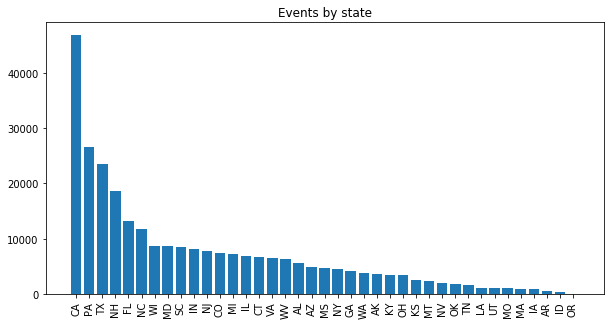

In [33]:
# Visualization for location of the events
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

value_counts = df_withchurn.groupBy('state').count().orderBy('count', ascending=False).toPandas()

pos = np.arange(0, len(value_counts))

ax.bar(pos, value_counts['count'].values, tick_label = value_counts['state'].values)

ax.set_title('Events by state')
    
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()

In [34]:

# calculate number of events for users who churned/stayed for each state
value_counts_ch = df_withchurn.where(df_withchurn['churn'] == True).groupBy('state').count().toPandas().sort_values('state')
value_counts_st = df_withchurn.where(df_withchurn['churn'] == False).groupBy('state').count().toPandas().sort_values('state')

In [35]:
# create lists of states in number of users who churned and stayed
churn_states = value_counts_ch['state'].values.tolist()
for state in value_counts_st['state'].values.tolist():
    if state not in churn_states:
        value_counts_ch = value_counts_ch.append({'state' : state, 'count' : 0}, ignore_index=True)
        
stay_states = value_counts_st['state'].values.tolist()
for state in value_counts_ch['state'].values.tolist():
    if state not in stay_states:
        value_counts_st = value_counts_st.append({'state' : state, 'count' : 0}, ignore_index=True)

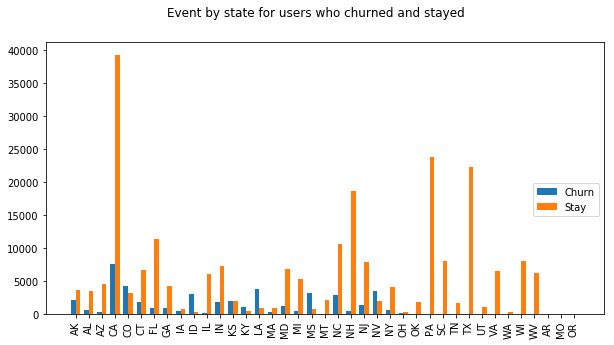

In [36]:
# Visuals

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

st = fig.suptitle("Event by state for users who churned and stayed")

pos = np.arange(0, len(value_counts_st['count'].values))
width = 0.35

p1 = ax.bar(pos, value_counts_ch['count'].values.tolist(), width, tick_label = value_counts_ch['state'].values.tolist())
p2 = ax.bar(pos + width, value_counts_st['count'].values.tolist(), width, tick_label = value_counts_st['state'].values.tolist())

ax.legend((p1[0], p2[0]), ('Churn', 'Stay'), bbox_to_anchor=(1, 0.5))

level_ax.set_title('level')
ax.set_xticks(pos + width / 2)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()

The graph above shows that states differ by churn rate: there are some states with events related only to users who stayed and there are also states, where there is significant number of events related to users, who churned.

### Conclusions:
We can't say anything about the difference in gender and level for users who churned vs users who stayed, because for these columns the more users/events there are the more there are users/events related to churn.
User's agent and song length features are not very informative for the analysis of the churn.
Location feature (state of the event) might be informative, because there are states with high and low churn rates.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [4]:
def clean_df(df):
    
    """
    This function is used to clean the row dataset
    input: dataframe to be cleaned
    output: final clean dataframe 
    """   
    # drop na values from the userId, sessionId
    df_clean = df.dropna(how = "any", subset = ["userId", "sessionId"]).dropDuplicates()
    # drop empty values from the userId
    df_clean = df_clean.filter(df_clean["userId"] != "")
    
    return df_clean

In [5]:
def features_enginering(df):
    '''
    Function for preparation of dataset for machine learning
    INPUT:
    df - initial dataset loaded from json file
    
    OUTPUT:
    df_ml - new dataset prepared for machine learning
    contains the following columns:
    1. userId - initial id of the user
    2. gender - user's gender
    3. avg_events - average number of events per day for the user
    4. avg_songs - average number of songs the user listens to per day
    5. thumbs_up - number of thumbs up events
    6. thumbs_down - number of thumbs down events
    7. active_days - days since user's firts event
    8. last_location - location of the last event
    9. last_level - user's last level (paid or free)
    10. addfriends - number of add friends events
    '''
    
    # clean dataset using clean_data function
    df = clean_df(df)
    
    # define cancellation udf
    cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    
    # set churn = 1 for rows where page == 'Cancellation Confirmation'
    df = df.withColumn("churn", cancellation_event("page"))
    
    
    # get userId with churn == 1
    cancelled_users = df.select(['userId', 'churn']).where(df.churn == 1).groupby('userId').count().toPandas()['userId'].values
    
    # create udf, which sets churn of a row to 1 if userId is in cancelled_users list
    def replace_data(userId, features):
        if(userId in cancelled_users): return 1
        else : return 0
    
    # set churn == 1 for all rows for users who cancelled their subscription
    fill_array_udf = udf(replace_data, IntegerType())
    df = df.withColumn("churn", fill_array_udf(col("userId"), col("churn")))
        
    # set column last ts with the first and the last event timestamp
    w = Window.partitionBy('userId')
    df = df.withColumn('last_ts', max('ts').over(w))
    df = df.withColumn('first_ts', min('ts').over(w))
    
    # convert timestamp to date (string)
    def get_date(ts):
        return str(datetime.utcfromtimestamp(ts / 1000).strftime('%Y-%m-%d'))
    
    get_date_from_ts_udf = udf(get_date, StringType())
    df = df.withColumn('last_date', get_date_from_ts_udf(col('last_ts')))
    df = df.withColumn('first_date', get_date_from_ts_udf(col('first_ts')))
    
    # add column date and convert timetamp to date
    df = df.withColumn('date', get_date_from_ts_udf(col('ts')))
    
    # set column last_level to level when timestamp is last timestamp
    df = df.withColumn('last_level', when(df.last_ts == df.ts, df.level))
    
    #aditional feature: Gender
    flag_gender = udf(lambda x: 1 if x == 'M' else 0, IntegerType())
    gender = df.select("userId", "gender").dropDuplicates()
    gender = df.withColumn("gender", flag_gender("gender"))
    
    # create column avg_songs to calculate average number of events per day
    w = Window.partitionBy('userId', 'date')
    events = df.select('userId', 'date', count('userId').over(w).alias('events')).distinct()
    w = Window.partitionBy('userId')
    events = events.withColumn('avg_events', avg('events').over(w))
    events = events.select(col("userId").alias("events_userId"), 'avg_events')
    events = events.withColumn("avg_events", round(events["avg_events"], 2))
    
    # create column avg_songs to calculate average number of songs per day
    w = Window.partitionBy('userId', 'date')
    songs = df.where(df.page == 'NextSong').select('userId', 'date', count('userId').over(w).alias('songs')).distinct()
    w = Window.partitionBy('userId')
    songs = songs.withColumn('avg_songs', avg('songs').over(w))
    songs = songs.select(col("userId").alias("songs_userId"), 'avg_songs')
    songs = songs.withColumn("avg_songs", round(songs["avg_songs"], 2))
    
    # calculate number of thumbs up for a user
    w = Window.partitionBy('userId')
    thumbsup = df.where(df.page == 'Thumbs Up').select('userId', count('userId').over(w).alias('thumbs_up')).distinct()
    thumbsup = thumbsup.select(col("userId").alias("thumbsup_userId"), 'thumbs_up')
    
    # calculate number of thumbs down for a user
    w = Window.partitionBy('userId')
    thumbsdown = df.where(df.page == 'Thumbs Down').select('userId', count('userId').over(w).alias('thumbs_down')).distinct()
    thumbsdown = thumbsdown.select(col("userId").alias("thumbsdown_userId"), 'thumbs_down')
    
    # calculate days since the date of the first event
    df = df.withColumn("days_active", 
              datediff(to_date(lit(datetime.now().strftime("%Y-%m-%d %H:%M"))),
                       to_date("first_date","yyyy-MM-dd")))
        
    # add column with state of the event based on location column
    def get_state(location):
        location = location.split(',')[-1].strip()
        if (len(location) > 2):
            location = location.split('-')[-1].strip()
    
        return location
    
    state_udf = udf(get_state, StringType())
    df = df.withColumn('state', state_udf(col('location')))
    
    #add column with last location of the user
    df = df.withColumn('last_state',when(df.last_ts == df.ts, df.state))
    
    # calculate number of add friends for a user
    w = Window.partitionBy('userId')
    addfriend = df.where(df.page == 'Add Friend').select('userId', count('userId').over(w).alias('addfriend')).distinct()
    addfriend = addfriend.select(col("userId").alias("addfriend_userId"), 'addfriend')
    
    # merge all results together
    df_ft = df.select('userId', 'gender', 'churn', 'last_level', 'days_active', 'last_state')\
    .dropna().drop_duplicates()
    
    df_ft = df_ft.join(songs, df_ft.userId == songs.songs_userId).distinct()
    df_ft = df_ft.join(events, df_ft.userId == events.events_userId).distinct()
    df_ft = df_ft.join(thumbsup, df_ft.userId == thumbsup.thumbsup_userId, how='left').distinct()
    df_ft = df_ft.fillna(0, subset=['thumbs_up'])
    df_ft = df_ft.join(thumbsdown, df_ft.userId == thumbsdown.thumbsdown_userId, how='left').distinct()
    df_ft = df_ft.fillna(0, subset=['thumbs_down'])
    df_ft = df_ft.join(addfriend, df_ft.userId == addfriend.addfriend_userId, how='left').distinct()
    df_ft = df_ft.fillna(0, subset=['addfriend'])
    df_ft = df_ft.drop('songs_userId','events_userId', 'thumbsup_userId', 'thumbsdown_userId', 'addfriend_userId')
    
    return df, df_ft

In [39]:
    # set column last ts with the first and the last event timestamp
    w = Window.partitionBy('userId')
    df = df.withColumn('last_ts', max('ts').over(w))
    df = df.withColumn('first_ts', min('ts').over(w))

In [40]:
df

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, time: string, last_ts: bigint, first_ts: bigint]

In [6]:
#df_medium = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkly-donotdelete-pr-xd5vv9g8psteli'))
df_ml.persist()

df_clean, df_ft = features_enginering(df_ml)

In [42]:
df_clean.show(2)

+--------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-------------+-------------+----------+----------+----------+----------+-----------+-----+----------+
|  artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|      last_ts|     first_ts| last_date|first_date|      date|last_level|days_active|state|last_state|
+--------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-------------+-------------+----------+----------+----------+----------+-----------+-----+----------+
|    Bebe|Logged In| Darianna|     F|            1|C

In [43]:
df_ft.head(2)

[Row(userId='91', gender='M', churn=0, last_level='paid', days_active=509, last_state='CT', avg_songs=151.76, avg_events=177.29, thumbs_up=124, thumbs_down=24, addfriend=42),
 Row(userId='300005', gender='F', churn=0, last_level='paid', days_active=509, last_state='VA', avg_songs=52.0, avg_events=65.67, thumbs_up=35, thumbs_down=4, addfriend=8)]

In [44]:
df_ft.count() # user count check

225

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

## 1. Split into Train, Test and Validations Sets:

In [7]:
# split into train, test and validation sets (60% - 20% - 20%)
df_ft = df_ft.withColumnRenamed("churn", "label")

train, test_valid = df_ft.randomSplit([0.6, 0.4], seed = 42)
test, validation = test_valid.randomSplit([0.5, 0.5], seed = 42)


## 2. Machine Learning Pipelines:
Global feature for ML Pipeline:

In [8]:
# index and encode categorical features gender, level and state

stringIndexerGender = StringIndexer(inputCol="gender", outputCol="genderIndex", handleInvalid = 'skip')
stringIndexerLevel = StringIndexer(inputCol="last_level", outputCol="levelIndex", handleInvalid = 'skip')
stringIndexerState = StringIndexer(inputCol="last_state", outputCol="stateIndex", handleInvalid = 'skip')

encoder = OneHotEncoderEstimator(inputCols=["genderIndex", "levelIndex", "stateIndex"],
                                       outputCols=["genderVec", "levelVec", "stateVec"],
                                handleInvalid = 'keep')

# create vector for features
features = ['genderVec', 'levelVec', 'stateVec', 'days_active', 'avg_songs', 'avg_events', 'thumbs_up', 'thumbs_down', 'addfriend']
assembler = VectorAssembler(inputCols=features, outputCol="features")

In [9]:
def predict(train, test, pipeline):
    model = pipeline.fit(train)
    pred_train = model.transform(train)
    pred_test = model.transform(test)
    
    
    predictionAndLabels_train = pred_train.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

    # Instantiate metrics object for train set
    metrics_train = MulticlassMetrics(predictionAndLabels_train)
    
    
    predictionAndLabels_test = pred_test.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

    # Instantiate metrics object for train set
    metrics_test = MulticlassMetrics(predictionAndLabels_test)
    
    
    # Area under precision-recall curve
    print("F1 score on train dataset is %s" % metrics_train.fMeasure())
    
    # Area under precision-recall curve
    print("F1 score on test dataset is %s" % metrics_test.fMeasure())
 
   




In [10]:
def model_tunning(paramGrid,train, test, pipeline):
    
    crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
    
    cvModel = crossval.fit(train)
    bestModel = cvModel.bestModel
    pred_test = bestModel.transform(test)

    predictionAndLabels_tunning = pred_test.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

    # Instantiate metrics object
    metrics_tunning = MulticlassMetrics(predictionAndLabels_tunning)

    # Area under precision-recall curve
    print("F1 score on test dataset is %s" % metrics_tunning.fMeasure())
    
    # get parameters
    params = [{p.name: v for p, v in m.items()} for m in cvModel.getEstimatorParamMaps()]

    # convert validation results to pandas dataframe
    validation_results = pd.DataFrame.from_dict([
        {cvModel.getEvaluator().getMetricName(): metric, **ps} 
        for ps, metric in zip(params, cvModel.avgMetrics)
    ])
    
    return validation_results

### Logistic Regression classifier:

In [49]:
# initialize logistic regression
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")

# assemble pipeline
pipeline = Pipeline(stages = [stringIndexerGender, stringIndexerLevel, stringIndexerState, encoder, assembler, lr])


In [50]:
# prediction using logistic regression

predict(train, test, pipeline)

F1 score on train dataset is 0.7480314960629921
F1 score on test dataset is 0.8636363636363636


In [51]:
# tunning for logistic regression

paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10, 30, 50]) \
    .addGrid(lr.regParam, [0.1, 0.3]) \
    .addGrid(lr.elasticNetParam, [0.8])\
    .addGrid(lr.family, ['auto'])\
    .build()

model_tunning(paramGrid, train, test, pipeline)

F1 score on test dataset is 0.8636363636363636


,elasticNetParam,f1,family,maxIter,regParam
0,0.8,0.643111,auto,10,0.1
1,0.8,0.643111,auto,10,0.3
2,0.8,0.643111,auto,30,0.1
3,0.8,0.643111,auto,30,0.3
4,0.8,0.643111,auto,50,0.1
5,0.8,0.643111,auto,50,0.3


## Random Forest Classifier:

In [11]:
# initialize random forest classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

# assemble pipeline
pipeline_rf = Pipeline(stages = [stringIndexerGender, stringIndexerLevel, stringIndexerState, encoder, assembler, rf])

In [53]:
# prediction for Random forest
predict(train, test, pipeline_rf)

F1 score on train dataset is 0.7952755905511811
F1 score on test dataset is 0.8636363636363636


In [14]:
# tunning for random forest
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30, 50, 100]) \
    .addGrid(rf.maxDepth, [3, 5, 10]) \
    .addGrid(rf.impurity, ['entropy', 'gini'])\
    .build()


model_tunning(paramGrid_rf, train, test, pipeline_rf)

F1 score on test dataset is 0.8823529411764706


,f1,impurity,maxDepth,numTrees
0,0.649205,entropy,3,10
1,0.652743,gini,3,10
2,0.687553,entropy,5,10
3,0.683226,gini,5,10
4,0.685746,entropy,10,10
5,0.710614,gini,10,10
6,0.649205,entropy,3,20
7,0.645580,gini,3,20
8,0.661653,entropy,5,20
9,0.671526,gini,5,20


## Gradient-boosted tree classifier:

In [11]:
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

# assemble pipeline
pipeline_gbt = Pipeline(stages = [stringIndexerGender, stringIndexerLevel, stringIndexerState, encoder, assembler, gbt])

In [12]:
# prediction for GBT
predict(train, test, pipeline_gbt)

F1 score on train dataset is 0.9921259842519685
F1 score on test dataset is 0.6818181818181818


In [12]:
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20, 40]) \
    .addGrid(gbt.maxDepth, [2, 3, 5]) \
    .build()

model_tunning(paramGrid_gbt, train, test, pipeline_gbt)

F1 score on test dataset is 0.8235294117647058


,f1,maxDepth,maxIter
0,0.656799,2,10
1,0.642743,3,10
2,0.625535,5,10
3,0.694073,2,20
4,0.671279,3,20
5,0.625535,5,20
6,0.682275,2,40
7,0.666023,3,40
8,0.602759,5,40


## Naive Bayes classifier:

In [15]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

# assemble pipeline
pipeline_nb = Pipeline(stages = [stringIndexerGender, stringIndexerLevel, stringIndexerState, encoder, assembler, nb])

In [14]:
# prediction for GBT
predict(train, test, pipeline_nb)

F1 score on train dataset is 0.4881889763779528
F1 score on test dataset is 0.5454545454545454


In [21]:
paramGrid_nb = ParamGridBuilder() \
    .addGrid(nb.smoothing, [1.0, 0.5]) \
    .build()

model_tunning(paramGrid_nb, train, test, pipeline_nb)

F1 score on test dataset is 0.5454545454545454


,f1,smoothing
0,0.503275,1.0
1,0.506637,0.5


## Validation result comparism

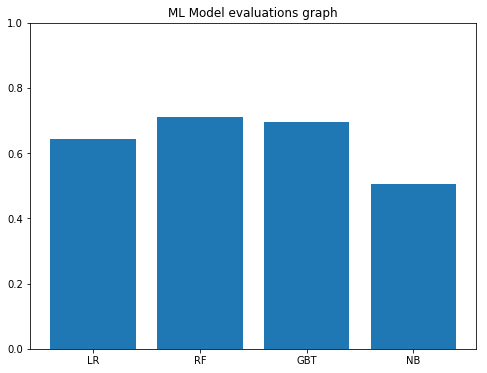

In [16]:
# plot diagram with model evaluation results

models = ['LR', 'RF', 'GBT', 'NB']
performance = [0.643111, 0.710614, 0.694073, 0.506637]

fig, ax = plt.subplots(figsize=(8, 6))

x_pos = np.arange(0, 4)

ax.bar(x_pos, performance, tick_label = models)
ax.set_title('ML Model evaluations graph')

plt.ylim(0, 1)
plt.show()

## Implementation using Best ML model on validation (i.e. RF)

In [12]:
model = pipeline_rf.fit(train)
pred_train = model.transform(train)                     
pred_test = model.transform(test)

bestModel = pipeline_rf.fit(train)

pred_validation = bestModel.transform(validation)

predictionAndLabels = pred_test.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Area under precision-recall curve
print("F1 score on validation dataset is %s" % metrics.fMeasure())



F1 score on validation dataset is 0.782608695652174


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.